<a href="https://colab.research.google.com/github/ankitdsi2010/ECE_LBP/blob/main/QKNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.utils import shuffle
from sklearn import datasets
from sklearn.metrics import accuracy_score

import itertools
import numbers
from collections import defaultdict
from typing import Optional, List, Union, Dict

import qiskit as qk
import qiskit.extensions.quantum_initializer as qi
import qiskit.circuit as qcirc
import qiskit.circuit.instruction as qinst
import qiskit.result as qres
import qiskit.tools as qktools
import qiskit.utils as qutils
import qiskit.providers as qkp
from qiskit.exceptions import QiskitError

UnionQInstBaseB = Union[qutils.QuantumInstance, qkp.BaseBackend]
OptionalQInstance = Optional[UnionQInstBaseB]

%matplotlib inline

In [ ]:
def encode(classical_data: np.ndarray) -> np.ndarray:
    amplitudes = np.sqrt(np.einsum('ij,ij->i', classical_data, classical_data))
    amplitudes[amplitudes == 0] = 1
    normalised_data = classical_data / amplitudes[:, np.newaxis]
    return normalised_data

In [ ]:
def init_to_state(reg_to_init: qk.QuantumRegister, 
                  init_state: np.ndarray, 
                  name: Optional[str] = None) -> qcirc.Gate:
    if len(init_state) != 2 ** len(reg_to_init):
      raise ValueError(
          "Dimensionality of the init_state does not coincide with the "
          "length of the register to initialise to: is {0} and {1}".format(
              len(init_state), len(reg_to_init)
          )
      )
    init_circ = qk.QuantumCircuit(reg_to_init, name=name)
    init = qi.Isometry(init_state, 0, 0)
    init_circ.append(init, reg_to_init)
    basis_gates = ['u1', 'u2', 'u3', 'cx']
    transpiled = qk.transpile(init_circ, basis_gates=basis_gates)
    init_gate = transpiled.to_gate()
    return init_gate

def controlled_initialize(reg_to_init: qk.QuantumRegister,
                          init_state: np.ndarray,
                          num_ctrl_qubits: Optional[int] = 1,
                          name: Optional[str] = None) -> qcirc.ControlledGate:
    init_gate = init_to_state(reg_to_init, init_state, name)
    controlled_init = init_gate.control(num_ctrl_qubits=num_ctrl_qubits)
    return controlled_init

In [ ]:
def initialise_qknn(log2_dim: int,
                    log2_n_samples: int,
                    test_state: np.ndarray) -> qk.QuantumCircuit:
    if len(test_state) != 2 ** log2_dim:
      raise ValueError(
            "Dimensionality of test state or provided dimension not correct;"
            " test state dim is {0:d}, and dimension given is {1:d}".format(
                len(test_state), 2 ** log2_dim
            )
      )
    r_0 = qk.QuantumRegister(1, name='control')
    r_1 = qk.QuantumRegister(log2_dim, name='state_to_classify')
    r_2 = qk.QuantumRegister(log2_dim, name='train_states')
    r_3 = qk.QuantumRegister(log2_n_samples, name='comp_basis')
    c_0 = qk.ClassicalRegister(r_0.size, name='measure_control')
    c_1 = qk.ClassicalRegister(r_3.size, name='measure_comp_basis')
    init_circ = qk.QuantumCircuit(r_0, r_1, r_2, r_3, c_0, c_1)
    init = qi.Isometry(test_state, 0, 0)
    init.name = "init test state"
    init_circ.append(init, r_1)
    init_circ.barrier()
    print(f"Initialised circuit as:\n{init_circ.draw()}")
    return init_circ

def state_transformation(qknn_circ: qk.QuantumCircuit,
                         oracle: qinst.Instruction) -> qk.QuantumCircuit:
    [control, test_reg, train_reg, comp_basis] = qknn_circ.qregs
    qknn_circ.h(control)
    qknn_circ.h(comp_basis)
    qknn_circ.append(oracle, train_reg[:] + comp_basis[:])
    for psi_bit, phi_bit in zip(test_reg, train_reg):
      qknn_circ.cswap(control, psi_bit, phi_bit)
    qknn_circ.h(control)
    qknn_circ.barrier()
    print(f"transformed registers to circuit:\n{qknn_circ.draw()}")
    return qknn_circ

def add_measurements(qknn_circ: qk.QuantumCircuit) -> qk.QuantumCircuit:
    comp_basis_creg = qknn_circ.cregs[-1]
    comp_basis_qreg = qknn_circ.qregs[-1]
    qknn_circ.measure(qknn_circ.qregs[0], qknn_circ.cregs[0])
    for q_bit, c_bit in zip(comp_basis_qreg, reversed(comp_basis_creg)):
        qknn_circ.measure(q_bit, c_bit)
    print("Added measurements.")
    return qknn_circ

def where_to_apply_x(bin_num_length: int) -> List:
    powers_of_two = 2 ** np.arange(bin_num_length)
    indices = [
               [
                 idx for idx, val in enumerate(powers_of_two)
                 if val & (pos ^ (pos - 1)) == val 
               ] for pos in range(2 ** bin_num_length)
              ]
    return indices

def get_subsystem_counts(complete_system_counts: Dict[str, int], 
                          post_select_index: Optional[int] = None, 
                          post_select_flag: Optional[str] = None) -> List:
    mixed_measurements = list(complete_system_counts)
    subsystems_counts = [defaultdict(int) for _ in mixed_measurements[0].split()]
    for mixed_measurement in mixed_measurements:
        count = complete_system_counts[mixed_measurement]
        subsystem_measurements = mixed_measurement.split()
        for k, d_l in zip(subsystem_measurements, subsystems_counts):
            if (post_select_index is None
                    or subsystem_measurements[post_select_index] == post_select_flag):
                d_l[k] += count
    return [dict(d) for d in subsystems_counts]

In [ ]:
def construct_circuit(state_to_classify: np.ndarray,
                      oracle: qinst.Instruction,
                      add_measurement: bool) -> qk.QuantumCircuit:
    if len(np.array(state_to_classify).shape) != 1:
      raise ValueError(
            "Please only one data point to classify. Number of data points "
            "provided is: {}.".format(np.array(state_to_classify).shape[0])
      )
    state_dimension = len(state_to_classify)
    n = np.log2(state_dimension)
    m = oracle.num_qubits - n
    if ((n == 0) or not n.is_integer()) and  ((m == 0) or not m.is_integer()):
      raise ValueError(
            "Desired statevector length not a positive power of 2."
      )
    qknn_circ = initialise_qknn(n, m, state_to_classify)
    qknn_circ = state_transformation(qknn_circ, oracle)
    if add_measurement:
      qknn_circ = add_measurements(qknn_circ)
    print(f"Final circuit:\n{qknn_circ.draw(fold=90)}")
    return qknn_circ

def create_oracle(train_data: Union[List, np.ndarray]) -> qinst.Instruction:
    train_shape = np.shape(train_data)
    if len(train_shape) != 2:
      raise ValueError(
            "Provided training data not 2-dimensional. Provide"
            "a matrix of shape n_samples x dim"
      )
    m, n = np.log2(train_shape)
    if not m.is_integer():
      print(
            "Warn: Number of training states not a positive power of 2,"
            "adding extra qubit to comply."
      )
      m = np.ceil(m)
    r_train = qk.QuantumRegister(n, name='train_states')
    r_comp_basis = qk.QuantumRegister(m, name='comp_basis')
    controlled_inits = [qcirc.ControlledGate] * train_shape[0]
    oracle_circ = qk.QuantumCircuit(r_train, r_comp_basis, name='oracle')
    for i, train_state in enumerate(train_data):
      controlled_inits[i] = controlled_initialize(
                                r_train,
                                train_state,
                                num_ctrl_qubits = r_comp_basis.size,
                                name = "phi_{}".format(i)
                            )
    bin_num_length = r_comp_basis.size
    where_x = where_to_apply_x(bin_num_length)
    for i, (c_init, x_idx) in enumerate(zip(controlled_inits, where_x)):
      print(f"applying x-gates to: {x_idx}")
      oracle_circ.x(r_comp_basis[x_idx])
      oracle_circ.append(c_init, r_comp_basis[:] + r_train[:])
    print(f"Created oracle as:\n{oracle_circ.draw()}")
    return oracle_circ.to_instruction()

def create_qknn(state_to_classify: Union[List, np.ndarray],
                classified_states: Union[List, np.ndarray],
                add_measurement: bool = False) -> qk.QuantumCircuit:
    oracle = create_oracle(classified_states)
    return construct_circuit(
        state_to_classify, 
        oracle, 
        add_measurement
    )

In [ ]:
class QKNeighboursClassifier():

    def __init__(self, n_neighbours: int = 3,
                 train_dataset: Optional[np.ndarray] = None,
                 train_labels: Optional[np.ndarray] = None,
                 test_dataset: Optional[np.ndarray] = None,
                 data_points: Optional[np.ndarray] = None,
                 quantum_instance: OptionalQInstance = None) -> None:
        self.n_neighbours = n_neighbours
        self.class_to_label = None
        self.label_to_class = None
        self.num_classes = None
        self.train_dataset = train_dataset
        self.train_labels = train_labels
        self.test_dataset = test_dataset
        self.data_points = data_points
        self.quantum_instance = quantum_instance
    
    def fit(self, X: np.ndarray, 
            Y: np.ndarray) -> None:
        self.train_dataset = X
        self.train_labels = Y

    @staticmethod
    def construct_circuit(state_to_classify: np.ndarray,
                          oracle: qinst.Instruction,
                          add_measurement: bool = False) -> qk.QuantumCircuit:
        return construct_circuit(
                  state_to_classify, 
                  oracle,
                  add_measurement
               )
        
    @staticmethod
    def construct_circuits(data_to_predict,
                           train_data) -> qk.QuantumCircuit:
        measurement = True
        oracle = create_oracle(train_data)
        print("Starting parallel map for constructing circuits.")
        circuits = qktools.parallel_map(
            QKNeighboursClassifier.construct_circuit,
            data_to_predict,
            task_args = [oracle, measurement]
        )
        print("Done.")
        return circuits

    @staticmethod
    def execute_circuits(quantum_instance: UnionQInstBaseB,
                         circuits) -> qres.Result:
        print("Executing circuits")
        result = quantum_instance.execute(circuits)
        print("Done.")
        return result

    @staticmethod
    def get_circuit_results(self, circuits, quantum_instance: \
                            OptionalQInstance = None) -> qres.Result:
        self.quantum_instance = self.quantum_instance \
            if quantum_instance is None else quantum_instance
        if self.quantum_instance is None:
          raise QiskitError(
              "Either provide a quantum instance or set one up."
          )
        return QKNeighboursClassifier.execute_circuits(
            self.quantum_instance,
            circuits
        )

    @staticmethod
    def get_all_fidelities(circuit_results: qres.Result):
        print("Getting fidelity values.")
        all_counts = circuit_results.get_counts()
        num_qubits = len(list(all_counts[0].keys())[0]) - 2
        n_occurences = len(all_counts)
        n_datapoints = 2 ** num_qubits
        all_fidelities = np.empty(shape = (n_occurences, n_datapoints))
        for i, counts in enumerate(all_counts):
          all_fidelities[i] = QKNeighboursClassifier.calculate_fidelities(counts)
        print("Done.")
        return all_fidelities

    @staticmethod
    def setup_control_counts(control_counts: Dict[str, int]) -> Dict[str, int]:
        control_states = np.array(['0', '1'])
        if control_states[0] not in control_counts:
          to_substitute = int(control_states[0])
        elif control_states[1] not in control_counts:
          to_substitute = int(control_states[1])
        else:
          to_substitute = None
        if to_substitute is not None:
          sole_occurence = -1 * (to_substitute - 1)
          print(
              "Only one value is counted in the control qubit: {0:d},"
              "setting the counts of state {1:d} to 0."
              .format(sole_occurence, to_substitute)
          )
          control_counts = {
              str(to_substitute): 0,
              str(sole_occurence): control_counts[str(sole_occurence)]
          }
        return control_counts

    @staticmethod
    def calculate_fidelities(counts: Dict[str, int]) -> np.ndarray:
        subsystem_counts = get_subsystem_counts(counts)
        control_counts = QKNeighboursClassifier.setup_control_counts(
            subsystem_counts[1]
        )
        total_counts = control_counts['0'] + control_counts['1']
        fidelity_diff = np.abs(control_counts['0'] - control_counts['1'])
        exp_fidelity = fidelity_diff / total_counts
        num_qubits = len(list(subsystem_counts[0].keys())[0])
        comp_basis_states = \
            list(itertools.product(['0', '1'], repeat=num_qubits))
        fidelities = np.zeros(2 ** num_qubits, dtype=float)
        for comp_state in comp_basis_states:
          comp_state = ''.join(comp_state)
          fidelity = 0.0
          for control_state in control_counts.keys():
            state_str = comp_state + ' ' + control_state
            if state_str not in counts:
              print(
                  "State {0:s} not found in counts {1}. Adding"
                  "zero to contrast value."
                  .format(state_str, counts)
              )
              fidelity += 0
            else:
              fidelity += \
                      (-1) ** int(control_state) * (counts[state_str]) / \
                      control_counts[control_state] * (1 - (exp_fidelity) ** 2)
          index_state = int(comp_state, 2)
          fidelity *= 2 ** num_qubits / 2
          fidelity += exp_fidelity
          fidelities[index_state] = fidelity
        return fidelities

    def majority_vote(self, labels: np.ndarray, 
                      fidelities: np.ndarray) -> np.ndarray:
        print("Performing majority vote.")
        if np.any(fidelities < -0.2) or np.any(fidelities > 1.2):
          raise ValueError("Fidelities contain values outside range 0<=F<=1:"
                             f"{fidelities[fidelities < -0.2]}"
                             f"{fidelities[fidelities > 1.2]}")
        sorted_neighbours = np.argpartition(
              1 - fidelities,
              -self.n_neighbours
        )
        n_queries = len(labels)
        sorted_neighbours = sorted_neighbours[sorted_neighbours < n_queries]\
            .reshape(sorted_neighbours.shape[0], n_queries)
        if n_queries == 1:
          n_closest_neighbours = sorted_neighbours[:self.n_neighbours]
        else:
          n_closest_neighbours = sorted_neighbours[:, :self.n_neighbours]
        voter_labels = np.take(labels, n_closest_neighbours)
        if n_queries == 1:
          votes, counts = stats.mode(voter_labels)
        else:
          votes, counts = stats.mode(voter_labels, axis=1)
        print("Done.")
        return np.array(votes.real.flatten())

    def predict(self, data: np.ndarray) -> np.ndarray:
        circuits = self.construct_circuits(
            data, self.train_dataset
        )
        circuit_results = self.get_circuit_results(
            self, circuits = circuits
        )
        fidelities = self.get_all_fidelities(
            circuit_results
        )
        predicted_labels = self.majority_vote(
            self.train_labels,
            fidelities
        )
        return predicted_labels

In [ ]:
backend = qk.BasicAer.get_backend('qasm_simulator')
instance = qutils.QuantumInstance(backend, shots=10000)

qknn = QKNeighboursClassifier(
    n_neighbours = 3,
    quantum_instance = instance
)

iris = datasets.load_iris()
labels = np.array(iris.target)
raw_data = np.array(iris.data)

n_variables = 2
train_len = 16
test_len = 4

columns = list(iris.feature_names)[:n_variables]
encoded_data = np.array(encode(raw_data[:, :n_variables]))

sf_data, sf_labels = shuffle(encoded_data, labels)
train_data = sf_data[:train_len]
train_labels = sf_labels[:train_len]
test_data = sf_data[train_len:(train_len+test_len)]
test_labels = sf_labels[train_len:(train_len+test_len)]

qknn.fit(train_data, train_labels)
pred_labels = qknn.predict(test_data)

print(accuracy_score(test_labels, pred_labels))

applying x-gates to: [0, 1, 2, 3]
applying x-gates to: [0]
applying x-gates to: [0, 1]
applying x-gates to: [0]
applying x-gates to: [0, 1, 2]
applying x-gates to: [0]
applying x-gates to: [0, 1]
applying x-gates to: [0]
applying x-gates to: [0, 1, 2, 3]
applying x-gates to: [0]
applying x-gates to: [0, 1]
applying x-gates to: [0]
applying x-gates to: [0, 1, 2]
applying x-gates to: [0]
applying x-gates to: [0, 1]
applying x-gates to: [0]
Created oracle as:
                   ┌───────┐     ┌───────┐     ┌───────┐     ┌───────┐     »
train_states: ─────┤ phi_0 ├─────┤ phi_1 ├─────┤ phi_2 ├─────┤ phi_3 ├─────»
              ┌───┐└───┬───┘┌───┐└───┬───┘┌───┐└───┬───┘┌───┐└───┬───┘┌───┐»
comp_basis_0: ┤ X ├────■────┤ X ├────■────┤ X ├────■────┤ X ├────■────┤ X ├»
              ├───┤    │    └───┘    │    ├───┤    │    └───┘    │    ├───┤»
comp_basis_1: ┤ X ├────■─────────────■────┤ X ├────■─────────────■────┤ X ├»
              ├───┤    │             │    └───┘    │             │    ├───┤»


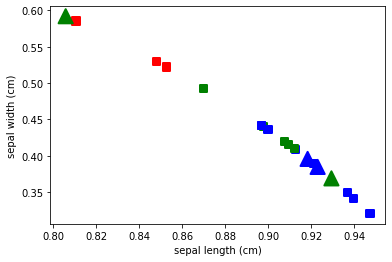

In [ ]:
def plot_graph(train_data, train_labels, test_data, pred_labels, columns):
    x1 = train_data[:,0]
    y1 = train_data[:,1]
    x2 = test_data[:,0]
    y2 = test_data[:,1]
    colors = ["red", "green", "blue"]
    c1 = [colors[i] for i in train_labels]
    c2 = [colors[i] for i in pred_labels]
    plt.scatter(x1, y1, c = c1,
                linewidths = 2,
                marker = "s",
                s = 50)
    plt.scatter(x2, y2, c = c2,
                linewidths = 2,
                marker = "^",
                s = 200)
    plt.xlabel("{}".format(columns[0]))
    plt.ylabel("{}".format(columns[1]))
    plt.show()

plot_graph(train_data, train_labels, test_data, pred_labels, columns)